<a href="https://colab.research.google.com/github/hakmin1015/ArtificialIntelligence/blob/main/Homework_4_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">

![header](https://capsule-render.vercel.app/api?type=soft&text=Training%20and%20Hyper-parameter%20setting%20with%20SGD%20and%20GD%20Methods&fontSize=25&fontAlignY=50&height=100&color=b2e39c)

|숙제번호|과목명|이름|전공|학번|
|:------:|:----:|:--:|:--:|:--:|
|Homework #4|인공지능|이학민|융합전자공학전공|201910906|

<img src="https://img.shields.io/badge/Python-3776AB?style=flat-square&logo=Python&logoColor=white"/> <img src="https://img.shields.io/badge/TensorFlow-FF6F00?style=flat-square&logo=tensorflow&logoColor=white"/> <img src="https://img.shields.io/badge/Google Colab-F9AB00?style=flat-square&logo=googlecolab&logoColor=white"/> <img src="https://img.shields.io/badge/Jupyter Notebook-F37626?style=flat-square&logo=jupyter&logoColor=white">
***



# 과제 설명
- Lab5의 code를 기본으로 하여 구현한다.
- SGD 방법으로 구현 (epoch=20, batch size = 100, 200, 1000 비교) <br/>
  (https://rfriend.tistory.com/548 / https://m.blog.naver.com/regenesis90/222343861167 참조)
- GD 방법과 차이를 설명하고 비교 그래프 출력 (loss vs epoch(mini batch가 아님))
- 가장 좋은 성능을 가질 수 있는 hyper-parameter set을 찾고 vanilla code의 성능과 비교함. (loss vs epoch)

## 0. 준비 작업
- 데이터 읽고 저장하기
- sigmoid 함수 정의
- L2 loss 코드 소개 (사용X, Softmax loss 사용)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/AI/lab5/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/AI/lab5


In [ ]:
import numpy as np
from numpy.random import randn

def unpickle(file):
  import pickle
  with open(file, 'rb') as fo:
    dict = pickle.load(fo, encoding='bytes')
  return dict

bat1 = unpickle('data_batch_1')
bat2 = unpickle('data_batch_2')
bat3 = unpickle('data_batch_3')
bat4 = unpickle('data_batch_4')
bat5 = unpickle('data_batch_5')
bat_test = unpickle('test_batch')

data = np.concatenate([bat1[b'data'], bat2[b'data'],
bat3[b'data'],bat4[b'data'], bat5[b'data']])
labels = np.concatenate([bat1[b'labels'],
bat2[b'labels'], bat3[b'labels'],bat4[b'labels'],
bat5[b'labels']])

t_data = bat1[b'data'].astype("float")
labels = bat1[b'labels']

N, D_in = np.shape(t_data)
H, D_out = 500, 10
t_label = np.zeros((N, D_out))

for i in range(N):
    t_label[i, labels[i]] = 1   # one hot vector

w1, w2 = randn(D_in, H) * 0.01, randn(H, D_out) * 0.01  # weight initialization

In [ ]:
def sigmoid(x: np.ndarray) -> np.ndarray:  # 안전한 version
    positives = x >= 0
    negatives = ~positives
    exp_x_neg = np.exp(x[negatives])
    y = x.copy()
    y[positives] = 1 / (1 + np.exp(-x[positives]))
    y[negatives] = exp_x_neg / (1 + exp_x_neg)
    return y

sigmoid_fn = lambda x: 1 / (1 + np.exp(-x))  # 일반 version
relu_fn = lambda x: x * (x > 0)

L2 Loss는 다음 코드로 구현할 수 있으며, 이번 과제에서는 Softmax Loss를 사용하였다.

In [ ]:
# L2 Loss

# for t in range(20):
#   z = np.dot(t_data,w1)
#   z -= np.max(z)
#   # h = sigmoid_fn(z)     #일반 sigmoid 함수
#   h = sigmoid(z)        # 안전한 sigmoid 함수
#   y_pred = h.dot(w2)
#   loss = np.square(y_pred - t_label).sum()
#   print(t, loss)

#   grad_y_pred = 2.0 * (y_pred - t_label)
#   grad_w2 = h.T.dot(grad_y_pred)
#   grad_h = grad_y_pred.dot(w2.T)
#   grad_w1 = t_data.T.dot(grad_h * h * (1-h))

#   lr = 1e-4
#   w1 -= lr * grad_w1
#   w2 -= lr * grad_w2

## 1. GD Method (Vanilla Code)
- 전체 데이터 셋을 이용하여 cost loss를 계산함.
- 전체 데이터셋을 반복해서 사용하기 때문에 계산 시간이 오래 걸릴 여지가 있음.
- cost 함수의 기울기를 정확히 계산하기 때문에 비교적 일정한 경로로 수렴하지만 큰 데이터셋에서는 수렴 속도가 느릴 수 있음.
- cost 함수가 복잡하고 여러 지역 최소값이 있을 때, 지역 최소값에 갇힐 가능성이 있음.

In [ ]:
import matplotlib.pyplot as plt

# Softmax loss

losses_GD = []  # List to store loss values

epoch = 20

for t in range(epoch):
    z = np.dot(t_data, w1)
    z -= np.max(z)
    # h = sigmoid_fn(z)     #일반 sigmoid 함수
    h = sigmoid(z)  # 안전한 sigmoid 함수
    z = h.dot(w2)
    z_max = np.max(z, axis=1)
    z -= z_max[:, None]

    exp_s = np.exp(z)
    exp_y_s = exp_s[range(len(labels)), labels]
    ti = exp_s / np.sum(exp_s, axis=1)[:, None]
    loss_i = -np.log(exp_y_s / np.sum(exp_s, axis=1))
    loss = np.sum(loss_i)
    losses_GD.append(loss)
    print(t, loss)

    grad_s = ti - t_label
    grad_w2 = h.T.dot(grad_s)
    grad_h = grad_s.dot(w2.T)
    grad_w1 = t_data.T.dot(grad_h * h * (1 - h))

    lr = 1e-4
    w1 -= lr * grad_w1
    w2 -= lr * grad_w2

0 23025.848195845665
1 23025.84816864156
2 23025.84814173592
3 23025.848115117195
4 23025.84808876745
5 23025.848062669393
6 23025.848036806914
7 23025.848011165013
8 23025.8479857297
9 23025.847960487943
10 23025.847935427555
11 23025.84791053716
12 23025.84788580608
13 23025.847861224356
14 23025.847836782632
15 23025.84781247213
16 23025.847788284624
17 23025.847764212383
18 23025.847740248166
19 23025.847716385135


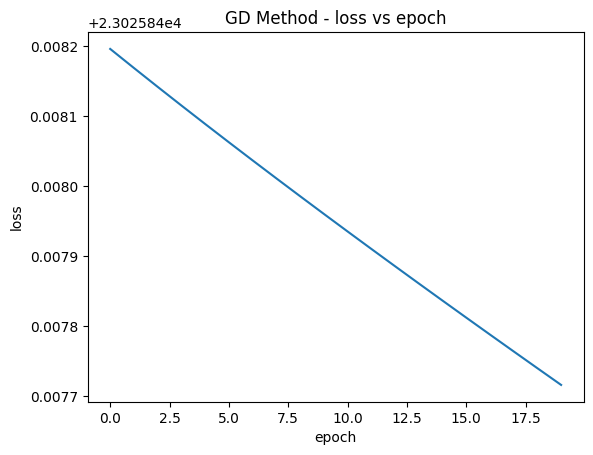

In [ ]:
# epoch에 따른 loss 그래프 출력

plt.plot(range(epoch), losses_GD)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('GD Method - loss vs epoch')
plt.show()

In [ ]:
# Test Set을 이용한 모델 정확도 측정

test_data = bat_test[b'data']
test_label = bat_test[b'labels']

z = np.dot(test_data, w1)
z -= np.max(z)
h = sigmoid(z)
ti = h.dot(w2)

Y_predict = np.argmax(ti, axis=1)
print(Y_predict)
acc = np.mean(Y_predict == test_label) * 100
print("The accuracy is %f " % acc)

[4 4 4 ... 4 4 4]
The accuracy is 9.750000 


## 2. SGD 방법 구현 (epoch = 20, batch size = 100, 200, 1000) <br/>
### <GD 방법과의 차이>
- 데이터셋에서 하나의 샘플을 무작위로 선택하여 기울기를 계산함.
- 한 번에 하나의 데이터 포인트만 사용하기 때문에 계산 비용이 낮음. 특히 대용량 데이터셋에 대해 매우 효율적임.
- 기울기가 불안정하게 계산되므로 수렴 경로가 흔들리며, 전체적으로 보면 빠르게 수렴할 수 있지만 불안정한 수렴 경로를 보일 수 있음.
- 불안정한 업데이트에 의해 지역 최소값에서 벗어날 가능성이 있고 이는 복잡한 cost 함수에서 더 나은 전역 최적값을 찾는 데 도움이 됨.

In [ ]:
t_data = bat1[b'data'].astype("float")

labels_1d = bat1[b'labels']
labels_arr = np.array(labels_1d)
labels = labels_arr.reshape(-1,1)

N, D_in = np.shape(t_data)
H, D_out = 500, 10

# Epoch
epoch = 20

# Code for mini batch
bat_size = 100
# bat_size = 200
# bat_size = 1000

repeat = int(N/bat_size)

t_label = np.zeros((bat_size, D_out, repeat))

import random

used_indices = set()
rand_indices_list = []
mini_batch_data = np.zeros((bat_size,D_in,repeat))
mini_batch_label = np.zeros((bat_size,1,repeat))

for i in range(repeat):
    available_indices = [idx for idx in range(N) if idx not in used_indices]
    rand_idx = np.random.choice(available_indices, bat_size, replace=False)

    used_indices.update(rand_idx)
    #rand_indices_list.append(rand_idx)    # random index for mini batch
    mini_batch_data[:,:,i] = t_data[rand_idx]
    mini_batch_label[:,:,i] = labels[rand_idx]

    mini_batch_label = mini_batch_label.astype('int')

    for j in range(bat_size):
      t_label[j,mini_batch_label[j,0,i],i] = 1

제시하는 L2 loss 코드는 다음과 같으며, 이번 과제에서는 Softmax loss를 중점으로 다룰 것이기 때문에 L2 loss는 epoch = 20, batch size = 100의 경우에서 실행한 결과만 간단하게 출력하였다.

In [ ]:
# L2 Loss

w1, w2 = randn(D_in, H)*0.01, randn(H, D_out)*0.01      # weight initialization

losses_all_L2 = []  # 모든 loss를 전부 저장할 리스트
losses_per_epoch_L2 = []  # 각 에폭의 loss 평균을 저장할 리스트

for t in range(epoch):
    print('epoch ' + str(t))
    losses_temp = []  # 각 epoch 별 loss를 저장할 리스트

    for i in range(repeat):
        t_data = mini_batch_data[:,:,i]
        z = np.dot(t_data, w1)

        # Batch Normalization
        z_mean = np.mean(z, axis=0)
        z_std = np.std(z, axis=0)
        z = (z - z_mean) / z_std

        z -= np.max(z)
        h = sigmoid(z)  # 안전한 sigmoid 함수
        y_pred = h.dot(w2)
        loss = np.square(y_pred - t_label[:,:,i]).sum()
        losses_temp.append(loss)
        losses_all_L2.append(loss)
        print(i, loss)

        grad_y_pred = 2.0 * (y_pred - t_label[:,:,i])
        grad_w2 = h.T.dot(grad_y_pred)
        grad_h = grad_y_pred.dot(w2.T)
        grad_w1 = t_data.T.dot(grad_h * h * (1 - h))

        lr = 1e-4
        w1 -= lr * grad_w1
        w2 -= lr * grad_w2

    # 각 epoch 별 loss의 평균을 구하여 저장함
    loss_epoch_avg = np.mean(losses_temp)
    losses_per_epoch_L2.append(loss_epoch_avg)

epoch 0
0 99.26419078310401
1 98.88611841112085
2 99.04232737043749
3 99.51547671918945
4 98.78165617047576
5 98.38386876939279
6 98.23011652481476
7 98.28547161642803
8 97.77873715093867
9 97.63216123988698
10 97.38610571330767
11 97.41680217190775
12 96.96479146350421
13 97.43373639728385
14 98.12222156988506
15 96.86195835254765
16 96.76547001864417
17 97.93809563773567
18 97.39045000388569
19 97.26744661432494
20 97.65882052121555
21 96.08868320059236
22 95.53494618065191
23 96.16545297041323
24 96.33718054348604
25 95.26693627015192
26 95.60067430488631
27 95.95074124251292
28 96.86337596206798
29 97.66203412135907
30 95.2496148799039
31 96.11508070389738
32 96.25860744784103
33 95.97988930747591
34 95.39353336299473
35 94.35016826796655
36 95.22590040242162
37 94.91244451548471
38 96.31669471268678
39 94.28672450194833
40 94.5640025129
41 95.8512415543508
42 96.80931810687011
43 95.53066751439304
44 93.32676253453293
45 92.93199364927897
46 93.4813019392806
47 94.83355167333443
4

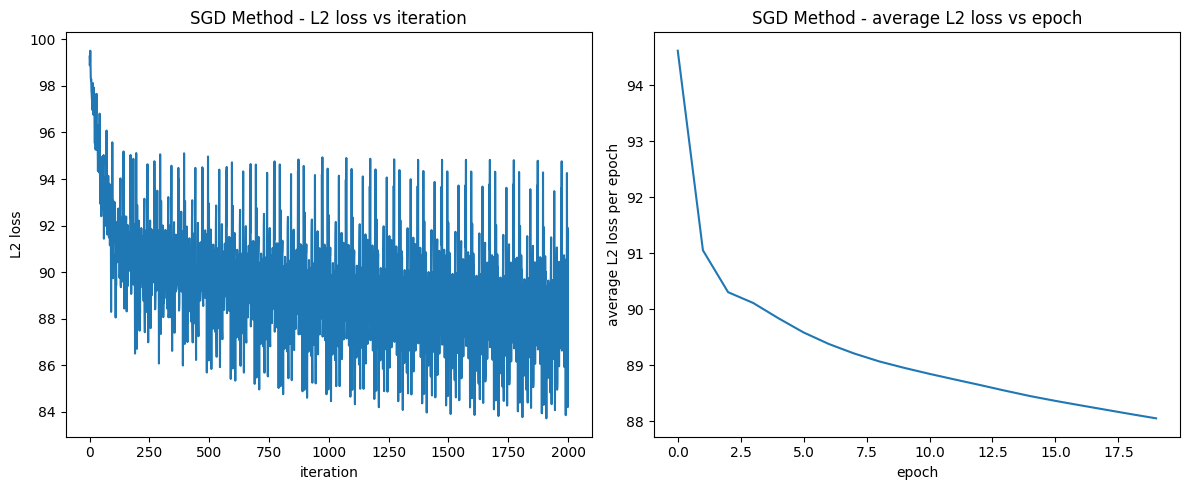

In [ ]:
# 그래프 출력

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses_all_L2)
plt.xlabel('iteration')
plt.ylabel('L2 loss')
plt.title('SGD Method - L2 loss vs iteration')

plt.subplot(1, 2, 2)
plt.plot(range(epoch), losses_per_epoch_L2)
plt.xlabel('epoch')
plt.ylabel('average L2 loss per epoch')
plt.title('SGD Method - average L2 loss vs epoch')

plt.tight_layout()
plt.show()

In [ ]:
# 정확도 측정

test_data = bat_test[b'data']
test_label = bat_test[b'labels']

z = np.dot(test_data, w1)
z -= np.max(z)
h = sigmoid(z)
ti = h.dot(w2)

Y_predict = np.argmax(ti, axis=1)
print(Y_predict)
acc = np.mean(Y_predict == test_label) *100
print("The accuracy is %f " % acc)

[0 0 0 ... 0 0 0]
The accuracy is 10.000000 


Softmax loss를 이용한 실습 과정

In [ ]:
# Softmax loss

losses_Softmax = []

w1, w2 = randn(D_in, H)*0.01, randn(H, D_out)*0.01      # weight initialization

losses_all_SoftMax = []  # 모든 loss를 전부 저장할 리스트
losses_per_epoch_SoftMax = []  # 각 에폭의 loss 평균을 저장할 리스트

for t in range(epoch):
    print('epoch ' + str(t))
    losses_temp = []  # 각 epoch 별 loss를 저장할 리스트

    for i in range(repeat):
        t_data = mini_batch_data[:,:,i]
        z = np.dot(t_data, w1)

        # Batch Normalization
        z_mean = np.mean(z, axis=0)
        z_std = np.std(z, axis=0)
        z = (z - z_mean) / z_std

        z -= np.max(z)
        h = sigmoid(z)  # 안전한 sigmoid 함수
        y_pred = h.dot(w2)
        z = h.dot(w2)
        z_max = np.max(z, axis=1)
        z -= z_max[:,None]
        exp_s = np.exp(z)
        exp_y_s = exp_s[range(len(t_label[:,:,i])),t_label[:,1,i].astype('int')]
        ti = exp_s / np.sum(exp_s, axis = 1)[:,None]
        loss_i = -np.log(exp_y_s/np.sum(exp_s, axis = 1))
        loss = np.sum(loss_i)
        losses_temp.append(loss)
        losses_all_SoftMax.append(loss)
        print(i, loss)

        grad_s = ti - t_label[:,:,i]
        grad_w2 = h.T.dot(grad_s)
        grad_h = grad_s.dot(w2.T)
        grad_w1 = t_data.T.dot(grad_h * h * (1-h))

        lr = 1e-4
        w1 -= lr * grad_w1
        w2 -= lr * grad_w2

    # 각 epoch 별 loss의 평균을 구하여 저장함
    loss_epoch_avg = np.mean(losses_temp)
    losses_per_epoch_SoftMax.append(loss_epoch_avg)

epoch 0
0 230.1910730981686
1 230.33182608853718
2 230.25594373934902
3 230.22599493810537
4 230.22087412998866
5 230.20682017658564
6 230.25012458995616
7 230.20568999018633
8 230.18823204423256
9 230.14295346395656
10 230.08938592526937
11 230.1896085031572
12 230.2130336903919
13 230.20753509891216
14 230.06345599021256
15 230.10768945454203
16 230.10263978644463
17 230.2213393062043
18 230.1472532900139
19 230.06872888778398
20 230.19877692225307
21 230.33085719544306
22 230.12794945560174
23 230.12697758325575
24 230.14462020580328
25 230.19411647850006
26 229.99300548844326
27 230.0771333778483
28 230.1408790552667
29 229.85417897421777
30 230.14076798783583
31 230.22761813774895
32 229.93380798133063
33 229.89293651479917
34 230.01519582105314
35 229.94639449524902
36 230.25817830990644
37 230.20897562450307
38 230.0762273716778
39 229.95570346297265
40 229.88082776352417
41 229.94498389308683
42 230.0701180695441
43 229.9266573076066
44 230.02371141434045
45 230.2888915498968
4

batch size = 100일 때 epoch vs loss 및 accuracy

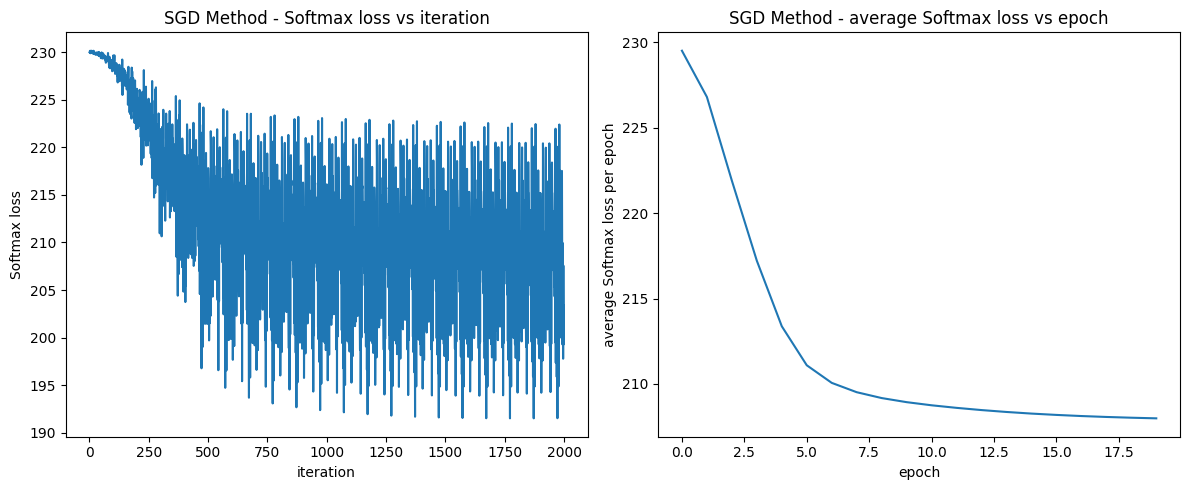

In [ ]:
# 그래프 출력

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses_all_SoftMax)
plt.xlabel('iteration')
plt.ylabel('Softmax loss')
plt.title('SGD Method - Softmax loss vs iteration')

plt.subplot(1, 2, 2)
plt.plot(range(epoch), losses_per_epoch_SoftMax)
plt.xlabel('epoch')
plt.ylabel('average Softmax loss per epoch')
plt.title('SGD Method - average Softmax loss vs epoch')

plt.tight_layout()
plt.show()

In [ ]:
test_data = bat_test[b'data'].astype("float")
test_label = bat_test[b'labels']

z = np.dot(test_data,w1)
z -= np.max(z)
h = sigmoid(z)
z = h.dot(w2)
z_max = np.max(z, axis=1)
z -= z_max[:,None]
exp_s = np.exp(z)
ti = exp_s / np.sum(exp_s, axis = 1)[:,None]
Y_predict = np.argmax(ti, axis=1)
acc = np.mean(Y_predict == test_label) *100
print("The accuracy is %f " % acc)

The accuracy is 9.990000 


batch size = 200일 때 epoch vs loss 및 accuracy

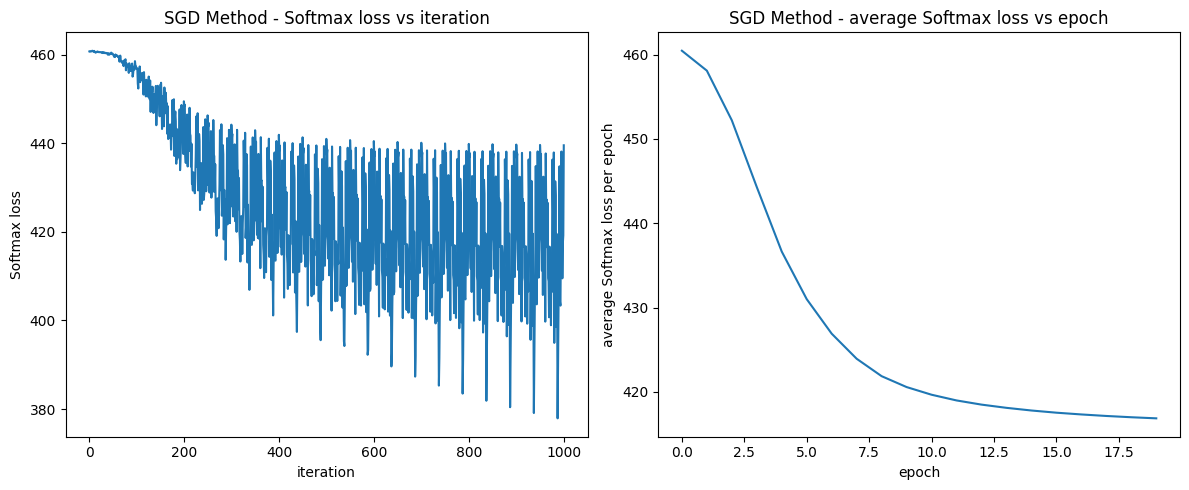

In [ ]:
# 그래프 출력

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses_all_SoftMax)
plt.xlabel('iteration')
plt.ylabel('Softmax loss')
plt.title('SGD Method - Softmax loss vs iteration')

plt.subplot(1, 2, 2)
plt.plot(range(epoch), losses_per_epoch_SoftMax)
plt.xlabel('epoch')
plt.ylabel('average Softmax loss per epoch')
plt.title('SGD Method - average Softmax loss vs epoch')

plt.tight_layout()
plt.show()

In [ ]:
test_data = bat_test[b'data'].astype("float")
test_label = bat_test[b'labels']

z = np.dot(test_data,w1)
z -= np.max(z)
h = sigmoid(z)
z = h.dot(w2)
z_max = np.max(z, axis=1)
z -= z_max[:,None]
exp_s = np.exp(z)
ti = exp_s / np.sum(exp_s, axis = 1)[:,None]
Y_predict = np.argmax(ti, axis=1)
acc = np.mean(Y_predict == test_label) *100
print("The accuracy is %f " % acc)

The accuracy is 9.990000 


batch size = 1000일 때 epoch vs loss 및 accuracy

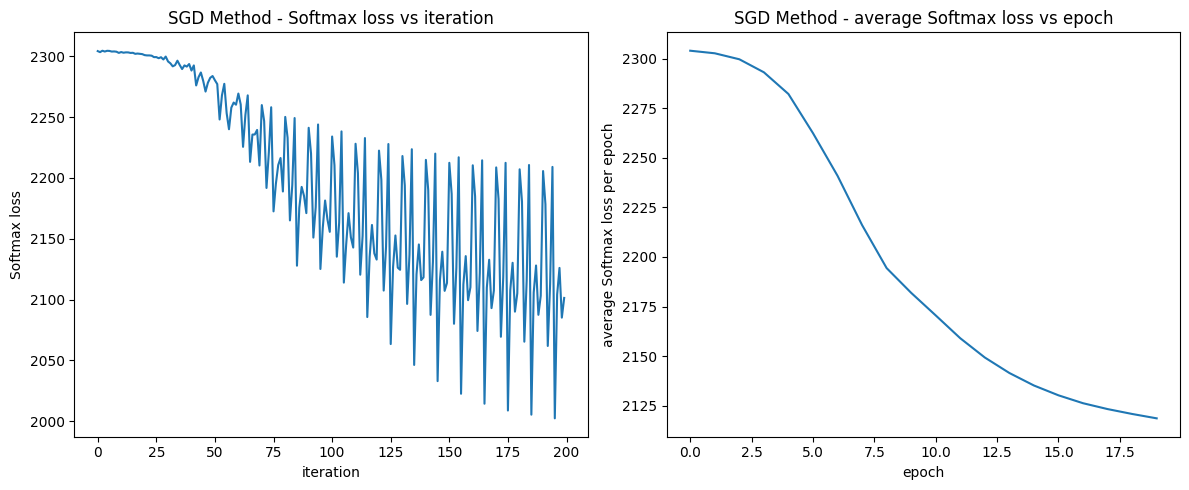

In [ ]:
# 그래프 출력

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(losses_all_SoftMax)
plt.xlabel('iteration')
plt.ylabel('Softmax loss')
plt.title('SGD Method - Softmax loss vs iteration')

plt.subplot(1, 2, 2)
plt.plot(range(epoch), losses_per_epoch_SoftMax)
plt.xlabel('epoch')
plt.ylabel('average Softmax loss per epoch')
plt.title('SGD Method - average Softmax loss vs epoch')

plt.tight_layout()
plt.show()

In [ ]:
test_data = bat_test[b'data'].astype("float")
test_label = bat_test[b'labels']

z = np.dot(test_data,w1)
z -= np.max(z)
h = sigmoid(z)
z = h.dot(w2)
z_max = np.max(z, axis=1)
z -= z_max[:,None]
exp_s = np.exp(z)
ti = exp_s / np.sum(exp_s, axis = 1)[:,None]
Y_predict = np.argmax(ti, axis=1)
acc = np.mean(Y_predict == test_label) *100
print("The accuracy is %f " % acc)

The accuracy is 10.000000 
